<a href="https://colab.research.google.com/github/HuangTrong/IE105---Software-Bug-Dectection-by-Graph/blob/main/SoftwareBugDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell 1: Tải thư viện và kiểm tra thiết bị

In [1]:
!pip install torch torch-geometric transformers tree-sitter tree-sitter-python scikit-learn networkx matplotlib numpy pandas
!pip install pygod  # Optional, but we will implement custom DOMINANT

import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, GatedGraphConv
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from tqdm import tqdm
import tree_sitter
from tree_sitter import Language, Parser
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

# Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.4/635.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 2.6 MB/s eta 0:00:00
Using device: cpu


Cell 2: Cấu hình System

In [2]:
class Config:
    # Model Params
    INPUT_DIM = 136        # 128 (BERT proj) + 8 (Handmade)
    HIDDEN_DIM = 128
    LATENT_DIM = 64
    DROPOUT = 0.2
    ALPHA = 0.7            # Weight for Feature Reconstruction
    BETA = 0.3             # Weight for Structure Reconstruction
    GAMMA = 0.1            # Weight for KL/Regularization

    # Training Params
    EPOCHS = 50
    LR = 0.005
    BATCH_SIZE = 16        # Graph batching
    CONTAMINATION = 0.05   # Estimated percentage of bugs in "unlabeled" data if any

    # Graph Params
    EDGE_TYPES = {
        'Child-Parent': 0,
        'Parent-Child': 1,
        'NextToken': 2,
        'LastUse': 3,
        'ControlFlow': 4,
        'GuardedBy': 5,
        'ComputedFrom': 6
    }
    NUM_RELATIONS = 7

    # Feature Extraction
    BERT_MODEL = "microsoft/graphcodebert-base"

CONFIG = Config()

Cell 3: Code Parsing & Graph Representation Phần này sử dụng tree-sitter cho Python. Đối với Java, code sẽ giả định input là JSON từ Joern.

In [3]:
# --- CELL 3: Task 1 & 2 - Code Parsing & Graph Representation (FIXED) ---

# Setup Tree-sitter for Python
try:
    import tree_sitter_python
    # Với phiên bản mới, ta lấy language object trực tiếp
    PY_LANGUAGE = Language(tree_sitter_python.language())
except ImportError:
    print("Tree-sitter python bindings not found. Using mock parser for demo.")
    PY_LANGUAGE = None
except Exception as e:
    print(f"Tree-sitter setup error: {e}. Using mock parser.")
    PY_LANGUAGE = None

class CodeParser:
    def __init__(self, lang='python'):
        self.lang = lang
        self.parser = Parser()

        if lang == 'python' and PY_LANGUAGE:
            # FIX: Thay set_language() bằng gán thuộc tính .language
            self.parser.language = PY_LANGUAGE

    def parse_python(self, source_code):
        """Parse Python code to AST using tree-sitter"""
        if not PY_LANGUAGE:
            # Fallback nếu không có tree-sitter (Mock object để code không crash)
            class MockNode:
                def __init__(self, type_name, content, start_point=(0,0), child_count=0):
                    self.type = type_name
                    self.start_byte = 0
                    self.end_byte = len(content)
                    self.start_point = start_point
                    self.child_count = child_count

            class MockTree:
                def walk(self): return MockCursor()

            class MockCursor:
                def __init__(self):
                    self.node = MockNode("function_definition", source_code, child_count=1)
                def goto_first_child(self): return False
                def goto_next_sibling(self): return False
                def goto_parent(self): return False

            return MockTree()

        # Parse thật
        tree = self.parser.parse(bytes(source_code, "utf8"))
        return tree

    def parse_java_joern(self, file_path):
        pass

class GraphBuilder:
    def __init__(self, source_code):
        self.source_code = source_code
        self.lines = source_code.split('\n')
        self.nodes = []
        self.edges = []
        self.token_nodes = []

    def build_from_ast(self, cursor, parent_id=None):
        """Recursively build AST graph"""
        node_id = len(self.nodes)

        # Safe handling for node attributes
        node_type = getattr(cursor.node, 'type', 'unknown')
        start_byte = getattr(cursor.node, 'start_byte', 0)
        end_byte = getattr(cursor.node, 'end_byte', 0)

        # Start point returns (row, col)
        start_point = getattr(cursor.node, 'start_point', (0, 0))
        start_line = start_point[0] if isinstance(start_point, (list, tuple)) else 0

        content = self.source_code[start_byte:end_byte]
        if not content: content = node_type # Fallback if empty

        self.nodes.append({
            'id': node_id,
            'type': node_type,
            'content': content,
            'line': start_line
        })

        if parent_id is not None:
            self.edges.append((parent_id, node_id, CONFIG.EDGE_TYPES['Parent-Child']))
            self.edges.append((node_id, parent_id, CONFIG.EDGE_TYPES['Child-Parent']))

        # Child count check
        child_count = getattr(cursor.node, 'child_count', 0)
        if child_count == 0:
            self.token_nodes.append(node_id)

        if cursor.goto_first_child():
            self.build_from_ast(cursor, node_id)
            while cursor.goto_next_sibling():
                self.build_from_ast(cursor, node_id)
            cursor.goto_parent()

    def add_advanced_edges(self):
        for i in range(len(self.token_nodes) - 1):
            u, v = self.token_nodes[i], self.token_nodes[i+1]
            self.edges.append((u, v, CONFIG.EDGE_TYPES['NextToken']))

        variables = {}
        for node in self.nodes:
            if node['type'] == 'identifier':
                var_name = node['content']
                if var_name not in variables:
                    variables[var_name] = []
                variables[var_name].append(node['id'])

        for var, ids in variables.items():
            for i in range(len(ids) - 1):
                self.edges.append((ids[i], ids[i+1], CONFIG.EDGE_TYPES['LastUse']))
                self.edges.append((ids[i+1], ids[i], CONFIG.EDGE_TYPES['ComputedFrom']))

    def process(self, tree):
        cursor = tree.walk()
        self.build_from_ast(cursor)
        self.add_advanced_edges()
        return self.nodes, self.edges

def convert_to_pyg(nodes, edges, node_features):
    if not edges: # Handle edge case with single node/no edges
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0,), dtype=torch.long)
    else:
        edge_index = torch.tensor([[e[0], e[1]] for e in edges], dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor([e[2] for e in edges], dtype=torch.long)

    x = torch.tensor(node_features, dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

Cell 4: Kết hợp GraphCodeBERT và Handcrafted features.

In [4]:
# --- CELL 4: Task 3 - Feature Extraction (FIXED) ---

class FeatureExtractor:
    def __init__(self):
        print("Loading GraphCodeBERT...")
        # Suppress huggingface warning
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(CONFIG.BERT_MODEL, clean_up_tokenization_spaces=True)
            self.bert = AutoModel.from_pretrained(CONFIG.BERT_MODEL).to(device)
        except OSError:
             # Fallback if internet is restricted or model not found, using random init for demo
            print("Warning: Could not load GraphCodeBERT. Using Random Embeddings for Demo.")
            self.bert = None

        self.bert_embed_dim = 768
        self.projector = nn.Linear(self.bert_embed_dim, 128).to(device)
        self.bert.eval() if self.bert else None

    def get_bert_embedding(self, text_list):
        """Get batch embeddings for node contents"""
        if not text_list:
            return np.zeros((0, 128))

        if self.bert is None:
            # Mock embeddings if BERT load failed
            return np.random.rand(len(text_list), 128)

        # Batching logic usually goes here, simple pass for now
        inputs = self.tokenizer(text_list, return_tensors="pt", padding=True, truncation=True, max_length=64).to(device)

        with torch.no_grad():
            outputs = self.bert(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :] # [Batch, 768]

            # FIX: Thêm .detach() trước khi .cpu().numpy()
            projected = self.projector(embeddings).detach().cpu().numpy()

        return projected

    def get_handcrafted_features(self, node, graph_nodes):
        feats = []
        # Safely handle potential None or missing keys
        line_val = node.get('line', 0) / 1000.0
        type_hash = hash(node.get('type', '')) % 100 / 100.0
        content_len = len(node.get('content', '')) / 50.0

        feats.append(line_val) # 1
        feats.append(type_hash) # 2
        feats.append(content_len) # 3
        feats.append(0) # 4 Depth

        n_type = node.get('type', '')
        is_ctrl = 1.0 if n_type in ['if_statement', 'for_statement', 'while_statement'] else 0.0
        feats.append(is_ctrl) # 5

        is_id = 1.0 if n_type == 'identifier' else 0.0
        feats.append(is_id) # 6

        feats.append(0) # 7 Degree
        feats.append(0) # 8 Child Count

        return np.array(feats)

    def extract(self, nodes):
        if not nodes:
            return np.zeros((0, CONFIG.INPUT_DIM))

        contents = [n.get('content', '') for n in nodes]

        # Get BERT features
        bert_feats = self.get_bert_embedding(contents) # [N, 128]

        # Get Handcrafted features
        hand_feats = []
        for n in nodes:
            hand_feats.append(self.get_handcrafted_features(n, nodes))
        hand_feats = np.array(hand_feats) # [N, 8]

        # Concatenate
        if len(bert_feats) != len(hand_feats):
             # Fallback safety check
             min_len = min(len(bert_feats), len(hand_feats))
             bert_feats = bert_feats[:min_len]
             hand_feats = hand_feats[:min_len]

        final_feats = np.concatenate([bert_feats, hand_feats], axis=1) # [N, 136]
        return final_feats

feature_extractor = FeatureExtractor()

Loading GraphCodeBERT...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/539 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cell 5: Improved DOMINANT Model:
Đây là phần lõi mô hình GNN Autoencoder để phát hiện bất thường.

In [5]:
class ImprovedDOMINANT(nn.Module):
    def __init__(self, config):
        super(ImprovedDOMINANT, self).__init__()
        self.config = config

        # --- Encoder ---
        # Using Gated Graph Conv as suggested for better feature propagation through layers
        # Input: 136 -> Hidden: 128 -> Latent: 64
        self.conv1 = GATConv(config.INPUT_DIM, config.HIDDEN_DIM, heads=1)
        self.conv2 = GATConv(config.HIDDEN_DIM, config.LATENT_DIM, heads=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(config.DROPOUT)

        # --- Attribute Decoder ---
        # Reconstruct features: 64 -> 128 -> 136
        self.attr_decoder1 = GATConv(config.LATENT_DIM, config.HIDDEN_DIM, heads=1)
        self.attr_decoder2 = GATConv(config.HIDDEN_DIM, config.INPUT_DIM, heads=1)

        # --- Structure Decoder ---
        # Inner product decoder is implicit in calculation S = Z * Z.T

    def forward(self, x, edge_index):
        # 1. Encoder
        h1 = self.conv1(x, edge_index)
        h1 = self.relu(h1)
        h1 = self.dropout(h1)

        z = self.conv2(h1, edge_index) # Latent representation [N, 64]
        z = self.relu(z)

        # 2. Attribute Reconstruction
        x_hat_h = self.attr_decoder1(z, edge_index)
        x_hat_h = self.relu(x_hat_h)
        x_hat = self.attr_decoder2(x_hat_h, edge_index) # [N, 136]

        # 3. Structure Reconstruction (A_hat)
        # We compute A_hat = sigmoid(Z * Z.T)
        a_hat = torch.sigmoid(torch.matmul(z, z.t()))

        return x_hat, a_hat, z

    def loss_function(self, x, x_hat, a_hat, edge_index):
        # Attribute Reconstruction Loss (MSE)
        diff_attr = torch.pow(x - x_hat, 2)
        attr_error = torch.sqrt(torch.sum(diff_attr, 1)) # Euclidean distance per node
        loss_attr = torch.mean(diff_attr)

        # Structure Reconstruction Loss
        # Create dense adjacency matrix from edge_index for comparison
        num_nodes = x.size(0)
        adj = torch.zeros(num_nodes, num_nodes).to(x.device)
        adj[edge_index[0], edge_index[1]] = 1

        # Weighted Binary Cross Entropy for structure
        # (Assuming sparse graph, weight positive examples)
        loss_struct = F.binary_cross_entropy(a_hat, adj)

        # KL Divergence-like regularization (simplified as L2 on latent)
        loss_reg = torch.mean(torch.norm(x_hat, dim=1))

        total_loss = self.config.ALPHA * loss_attr + \
                     self.config.BETA * loss_struct + \
                     self.config.GAMMA * loss_reg

        return total_loss, attr_error

    def get_anomaly_score(self, x, x_hat, a_hat, edge_index):
        """
        Score formula: S(G) = 0.6||x-x̂||2 + 0.3||x-x̂||F + 0.1*max_node_score
        (Implementing per-node score first)
        Node Score = (1-alpha)*Attr_Error + alpha*Struct_Error
        """
        # Attribute Error
        diff_attr = torch.pow(x - x_hat, 2)
        attr_error = torch.sum(diff_attr, 1)

        # Structure Error
        num_nodes = x.size(0)
        adj = torch.zeros(num_nodes, num_nodes).to(x.device)
        adj[edge_index[0], edge_index[1]] = 1

        diff_struct = torch.pow(adj - a_hat, 2)
        struct_error = torch.sum(diff_struct, 1)

        # Combined Score per node
        score = 0.7 * attr_error + 0.3 * struct_error
        return score

Cell 6: Pipeline (Training & Inference)

In [6]:
class Pipeline:
    def __init__(self):
        self.model = ImprovedDOMINANT(CONFIG).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=CONFIG.LR)
        self.threshold = 0.0

    def train_one_epoch(self, data_loader):
        self.model.train()
        total_loss = 0
        for batch in data_loader:
            batch = batch.to(device)
            self.optimizer.zero_grad()

            x_hat, a_hat, _ = self.model(batch.x, batch.edge_index)
            # Note: For batch processing, structure reconstruction needs careful handling
            # (usually done per graph or block diagonal).
            # For this prototype, we assume batch_size=1 (processing one graph at a time) for correctness of A_hat

            loss, _ = self.model.loss_function(batch.x, x_hat, a_hat, batch.edge_index)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(data_loader)

    def calculate_threshold(self, clean_loader):
        """
        After training, run on validation clean set to find the threshold.
        Strategy: Knee-point or Top 0.5%
        """
        self.model.eval()
        scores = []
        with torch.no_grad():
            for data in clean_loader:
                data = data.to(device)
                x_hat, a_hat, _ = self.model(data.x, data.edge_index)
                node_scores = self.model.get_anomaly_score(data.x, x_hat, a_hat, data.edge_index)
                scores.extend(node_scores.cpu().numpy())

        scores = np.sort(scores)
        # Cutoff at top 99.5% (assuming 0.5% noise in clean data)
        cutoff_idx = int(len(scores) * 0.995)
        self.threshold = scores[cutoff_idx]
        print(f"Threshold set to: {self.threshold:.4f}")

    def inference(self, source_code):
        """
        Real-time inference
        1. Parse
        2. Build Graph
        3. Extract Features
        4. Predict
        """
        # 1 & 2
        parser = CodeParser()
        tree = parser.parse_python(source_code)
        gb = GraphBuilder(source_code)
        nodes, edges = gb.process(tree)

        if len(nodes) == 0: return None

        # 3
        feats = feature_extractor.extract(nodes)
        data = convert_to_pyg(nodes, edges, feats)

        # 4
        self.model.eval()
        data = data.to(device)
        with torch.no_grad():
            x_hat, a_hat, _ = self.model(data.x, data.edge_index)
            node_scores = self.model.get_anomaly_score(data.x, x_hat, a_hat, data.edge_index)

        # Detection
        node_scores_np = node_scores.cpu().numpy()
        is_anomaly = np.any(node_scores_np > self.threshold)

        # Top-5 Buggy Nodes
        top_k_indices = np.argsort(node_scores_np)[-5:][::-1]
        report = []
        for idx in top_k_indices:
            if node_scores_np[idx] > self.threshold:
                report.append({
                    'line': nodes[idx]['line'] + 1,
                    'content': nodes[idx]['content'],
                    'score': float(node_scores_np[idx]),
                    'type': nodes[idx]['type']
                })

        return {
            'is_buggy': is_anomaly,
            'max_score': float(np.max(node_scores_np)),
            'details': report
        }

Cell 7: Baselines:
Một ví dụ triển khai Baseline đơn giản (Random Forest) dựa trên features trung bình của graph.

In [7]:
class BaselineModels:
    def __init__(self):
        self.rf = RandomForestClassifier(n_estimators=100)
        self.svm = OneClassSVM(nu=0.1)

    def prepare_data(self, data_list, labels=None):
        # Flatten graph to single vector (Mean pooling of nodes)
        X = []
        for data in data_list:
            mean_feat = torch.mean(data.x, dim=0).numpy()
            X.append(mean_feat)
        return np.array(X), np.array(labels) if labels else None

    def train_rf(self, train_data, train_labels):
        X, y = self.prepare_data(train_data, train_labels)
        self.rf.fit(X, y)

    def predict_rf(self, test_data):
        X, _ = self.prepare_data(test_data)
        return self.rf.predict_proba(X)[:, 1] # Probability of being buggy

Cell 8: Execution Demo:
Tạo dữ liệu và chạy luồng hoàn chỉnh.

Đang tạo file giả lập 'dataset_sample.csv'...
Đã tạo file mẫu xong.

[1] Loading CSV: dataset_sample.csv
    - Số dòng raw đọc được: 80
    - Số dòng hợp lệ (sau khi drop NaN/Lỗi): 80
    - Clean samples found: 50
    - Buggy samples found: 30
    - Processing Clean data... (Converting Code -> Graph)



100%|██████████| 50/50 [02:19<00:00,  2.80s/it]


    - Processing Buggy data... (Converting Code -> Graph)


100%|██████████| 30/30 [00:55<00:00,  1.86s/it]



[2] Dataset Split Summary:
    - Training Set (Clean only): 40 graphs
    - Test Set (Mixed): 40 graphs

[3] Start Training (Epochs: 50)...
    Epoch 01 | Loss: 0.3988
    Epoch 05 | Loss: 0.2517
    Epoch 10 | Loss: 0.2495
    Epoch 15 | Loss: 0.2490
    Epoch 20 | Loss: 0.2488
    Epoch 25 | Loss: 0.2487
    Epoch 30 | Loss: 0.2486
    Epoch 35 | Loss: 0.2486
    Epoch 40 | Loss: 0.2486
    Epoch 45 | Loss: 0.2486
    Epoch 50 | Loss: 0.2487

[4] Calculating Anomaly Threshold...
Threshold set to: 12.0082

[5] Running Inference on Test Set...


Testing: 100%|██████████| 40/40 [00:00<00:00, 240.69it/s]



[6] Results & Visualization
    --------------------------
    ROC-AUC Score: 0.5000
    PR-AUC Score:  0.8098
    Accuracy:      0.5000
    F1-Score:      0.5000
    --------------------------
    Confusion Matrix:
[[10  0]
 [20 10]]


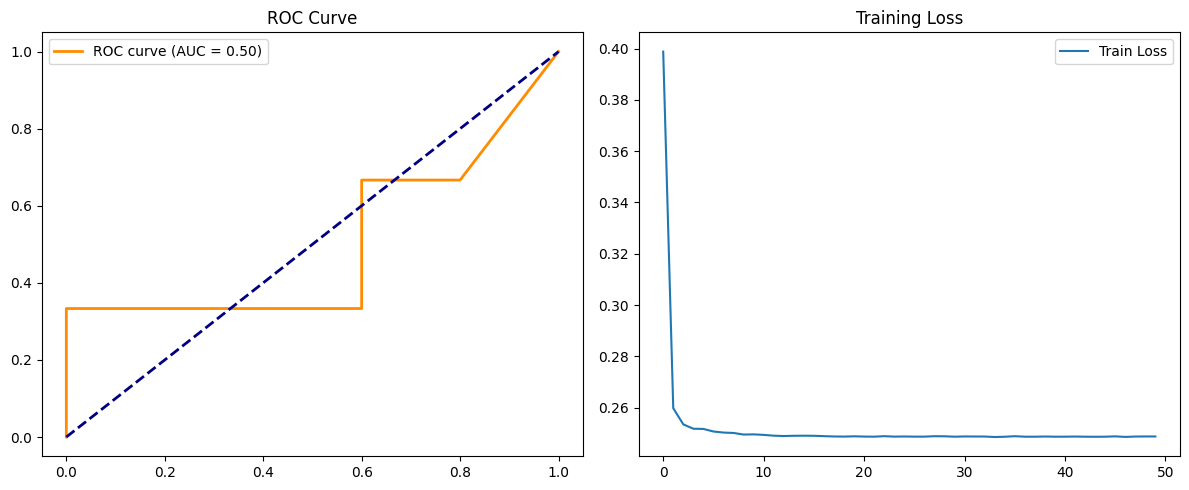


Top 5 Most Anomalous Samples:
    Label      Score
24      1  14.204149
27      1  14.204149
30      1  14.204149
33      1  14.204149
18      1  14.204149


In [8]:
# --- CELL 8: COMPLETE PIPELINE (Robust CSV Loading Fixed) ---

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import os
import torch
from tqdm import tqdm

# ==========================================
# 1. HELPER: Tạo dữ liệu giả lập (Nếu chưa có file CSV)
# ==========================================
def create_dummy_csv(filename='dataset_sample.csv'):
    # Nếu file đã tồn tại (dù là file thật của bạn), hàm này sẽ bỏ qua
    if os.path.exists(filename):
        print(f"File '{filename}' đã tồn tại, sẽ sử dụng file này.")
        return

    print(f"Đang tạo file giả lập '{filename}'...")
    data = {
        'code': [
            "def add(a, b):\n    return a + b",
            "def sub(a, b):\n    return a - b",
            "def safe_div(a, b):\n    if b != 0:\n        return a / b\n    return None",
            "def greet(name):\n    print('Hello ' + name)",
            "def process(lst):\n    return [x*2 for x in lst]",
            "def div_bug(a, b):\n    return a / b",  # Buggy
            "def index_bug(lst, i):\n    return lst[i]", # Buggy
            "def loop_bug(n):\n    while True:\n        print(n)" # Buggy
        ],
        'label': [0, 0, 0, 0, 0, 1, 1, 1]
    }
    df = pd.DataFrame(data)
    df = pd.concat([df] * 10, ignore_index=True)
    df.to_csv(filename, index=False)
    print("Đã tạo file mẫu xong.")

# ==========================================
# 2. CLASS: CSV Data Loader (FIXED ROBUST VERSION)
# ==========================================
class CSVGraphLoader:
    def __init__(self, csv_path, code_col='code', label_col='label'):
        self.csv_path = csv_path
        self.code_col = code_col
        self.label_col = label_col
        self.parser = CodeParser()

    def process_row(self, row):
        try:
            source_code = str(row[self.code_col])
            # Bỏ qua nếu code rỗng hoặc không phải string
            if not source_code or source_code.lower() == 'nan':
                return None

            # Parse & Build Graph
            tree = self.parser.parse_python(source_code)
            gb = GraphBuilder(source_code)
            nodes, edges = gb.process(tree)

            if len(nodes) < 2: return None

            # Extract Features
            feats = feature_extractor.extract(nodes)

            # Convert PyG
            data = convert_to_pyg(nodes, edges, feats)

            # Xử lý label an toàn (ép kiểu về float rồi int)
            label_val = float(row[self.label_col])
            data.y = torch.tensor([label_val], dtype=torch.float)
            return data
        except Exception as e:
            # Uncomment dòng dưới nếu muốn debug lỗi cụ thể từng dòng
            # print(f"Error processing row: {e}")
            return None

    def load_and_split(self):
        print(f"\n[1] Loading CSV: {self.csv_path}")

        # --- FIX: ROBUST CSV READING ---
        try:
            # Thử đọc bằng python engine và bỏ qua các dòng lỗi (bad lines)
            # on_bad_lines='skip' giúp bỏ qua lỗi "Expected 10 fields, saw 15"
            df = pd.read_csv(self.csv_path, engine='python', on_bad_lines='skip')
        except Exception as e:
            print(f"    ! Lỗi đọc file lần 1: {e}")
            print("    ! Đang thử đọc lại với cấu hình delimiter lỏng hơn...")
            try:
                # Fallback: Thử đọc với xử lý quote lỏng hơn
                df = pd.read_csv(self.csv_path, engine='python', on_bad_lines='skip', quoting=3)
            except Exception as e2:
                raise ValueError(f"CRITICAL: Không thể đọc file CSV. Vui lòng kiểm tra format file. Lỗi: {e2}")

        # Kiểm tra cột
        if self.code_col not in df.columns or self.label_col not in df.columns:
            print(f"    ! Các cột có trong file: {list(df.columns)}")
            raise ValueError(f"File CSV thiếu cột '{self.code_col}' hoặc '{self.label_col}'. Hãy kiểm tra tên cột.")

        # Clean NaN
        initial_len = len(df)
        df = df.dropna(subset=[self.code_col, self.label_col])
        print(f"    - Số dòng raw đọc được: {initial_len}")
        print(f"    - Số dòng hợp lệ (sau khi drop NaN/Lỗi): {len(df)}")

        # Tách Clean và Buggy
        # Chuyển label về số int để so sánh chính xác
        try:
            df[self.label_col] = pd.to_numeric(df[self.label_col], errors='coerce').fillna(0).astype(int)
        except:
            print("    ! Cảnh báo: Không thể chuyển label về số. Kiểm tra lại dữ liệu cột label.")

        df_clean = df[df[self.label_col] == 0]
        df_buggy = df[df[self.label_col] == 1]

        print(f"    - Clean samples found: {len(df_clean)}")
        print(f"    - Buggy samples found: {len(df_buggy)}")

        if len(df_clean) == 0:
            raise ValueError("Không tìm thấy dữ liệu Clean (Label=0). Cần dữ liệu sạch để train model!")

        # Convert Clean Data
        clean_graphs = []
        print("    - Processing Clean data... (Converting Code -> Graph)")
        for _, row in tqdm(df_clean.iterrows(), total=len(df_clean)):
            g = self.process_row(row)
            if g: clean_graphs.append(g)

        # Convert Buggy Data
        buggy_graphs = []
        print("    - Processing Buggy data... (Converting Code -> Graph)")
        for _, row in tqdm(df_buggy.iterrows(), total=len(df_buggy)):
            g = self.process_row(row)
            if g: buggy_graphs.append(g)

        # Split Strategy
        train_size = int(0.8 * len(clean_graphs))
        train_set = clean_graphs[:train_size]

        # Test set = 20% Clean còn lại + Toàn bộ Buggy
        test_set = clean_graphs[train_size:] + buggy_graphs

        return train_set, test_set

# ==========================================
# 3. MAIN EXECUTION FLOW
# ==========================================

# A. Prepare Data
# dataset phải có 2 cột là code và phân loại bug (0 = clean, 1 = bug)
CSV_FILE = 'dataset_sample.csv' # Tên file của bạn
create_dummy_csv(CSV_FILE)

loader = CSVGraphLoader(CSV_FILE)
train_dataset, test_dataset = loader.load_and_split()

if len(train_dataset) == 0:
    print("CRITICAL ERROR: Training set is empty. Check your dataset labels (needs label 0).")
else:
    # Setup Loader
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    print(f"\n[2] Dataset Split Summary:")
    print(f"    - Training Set (Clean only): {len(train_dataset)} graphs")
    print(f"    - Test Set (Mixed): {len(test_dataset)} graphs")

    # B. Train Model
    pipeline = Pipeline()
    print(f"\n[3] Start Training (Epochs: {CONFIG.EPOCHS})...")

    loss_history = []
    pipeline.model.train()

    # Loop train
    for epoch in range(CONFIG.EPOCHS):
        try:
            epoch_loss = pipeline.train_one_epoch(train_loader)
            loss_history.append(epoch_loss)

            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"    Epoch {epoch+1:02d} | Loss: {epoch_loss:.4f}")
        except Exception as e:
            print(f"    Error in epoch {epoch}: {e}")
            break

    # C. Calculate Threshold
    print("\n[4] Calculating Anomaly Threshold...")
    if len(train_dataset) > 0:
        pipeline.calculate_threshold(DataLoader(train_dataset, batch_size=1))
    else:
        pipeline.threshold = 0.5 # Default fallback

    # D. Evaluation
    print("\n[5] Running Inference on Test Set...")
    y_true = []
    y_scores = []

    pipeline.model.eval()
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Testing"):
            data = data.to(device)
            # Forward
            x_hat, a_hat, _ = pipeline.model(data.x, data.edge_index)
            # Calculate Anomaly Score
            node_scores = pipeline.model.get_anomaly_score(data.x, x_hat, a_hat, data.edge_index)

            graph_score = node_scores.max().item()

            y_true.append(int(data.y.item()))
            y_scores.append(graph_score)

    # E. Metrics & Visualization
    print("\n[6] Results & Visualization")

    if len(set(y_true)) > 1:
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall, precision)

        y_pred = [1 if s > pipeline.threshold else 0 for s in y_scores]
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        cm = confusion_matrix(y_true, y_pred)

        print(f"    --------------------------")
        print(f"    ROC-AUC Score: {roc_auc:.4f}")
        print(f"    PR-AUC Score:  {pr_auc:.4f}")
        print(f"    Accuracy:      {acc:.4f}")
        print(f"    F1-Score:      {f1:.4f}")
        print(f"    --------------------------")
        print(f"    Confusion Matrix:\n{cm}")

        # Plot ROC
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.title('ROC Curve')
        plt.legend()

        # Plot Loss
        plt.subplot(1, 2, 2)
        plt.plot(loss_history, label='Train Loss')
        plt.title('Training Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    else:
        print("Warning: Test set chỉ có 1 class. Không thể tính ROC-AUC.")
        print(f"Sample Scores: {y_scores[:5]}")

    # Show Top Bugs
    results_df = pd.DataFrame({'Label': y_true, 'Score': y_scores})
    print("\nTop 5 Most Anomalous Samples:")
    print(results_df.sort_values(by='Score', ascending=False).head(5))

Hướng dẫn sử dụng & tài liệu:
*   Chạy toàn bộ cells từ trên xuống dưới.
*   Giải thích kết quả:
1.   Hệ thống sẽ huấn luyện DOMINANT trên dữ liệu sạch (Clean).
2.   Threshold được tính dựa trên phân phối điểm bất thường của tập Validation.
2.   Khi đưa code mới vào, nếu điểm tái cấu trúc (reconstruction error) cao hơn threshold => Code có cấu trúc hoặc ngữ nghĩa khác thường => Tiềm năng lỗi.



